### Test fit

In [1]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import sys
from scipy import stats
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
from sympy.tensor.array import derive_by_array
from numpy import identity, array, dot, matmul
from latex2sympy2 import latex2sympy
from sympy import *
from time import time

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef
from ExternalFunctions import nice_string_output, add_text_to_ax, UnbinnedLH

#sys.path.append('C:\\Users\\Bruger\\BSc_project')
import oscillation_prob as op
import own_oscillation_prob as oop

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [2]:
Honda_rate_cc = np.genfromtxt('Honda_rate_spline_cc', delimiter=',')

Importing the oscillation code and running for values from http://www.nu-fit.org/?q=node/238

In [3]:
DM32_true = 2.51e-3
theta23_true = 42.1/180*np.pi

In [4]:
#t = time()
#prob_numu_to_numu_true, binned_prob_true = op.oscillation_prob(theta23_true, DM32_true)
#print(time() - t)

prob_numu_to_numu_true, binned_prob_true = oop.prob_numu_numu(theta23_true, DM32_true)

In [5]:
Honda_cc_oscillated = Honda_rate_cc * binned_prob_true
Honda_pseudo_data_cc = Honda_cc_oscillated.copy()

In [6]:
# Energy bins
energy_cropped = np.genfromtxt('energy_cropped')
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(energy_cropped, energy_min)
energy_binwidths = energy_max - energy_min

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

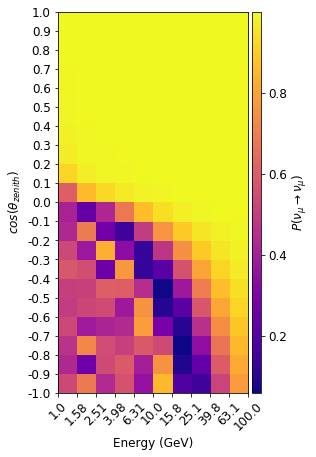

In [7]:
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(binned_prob_true, cmap='plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(energy_strings, rotation = 45)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
cbar.set_label(cbar_label)

#### $\chi^2$ fit function

In [8]:
def chi_squared(fit_function, fit_flux, pseudo_data, fit_parameters, guesses):
    
    def chi2_owncalc(*fit_parameters):
        prob_numu_to_numu, osc_prob = fit_function(*fit_parameters)
        fit_data = fit_flux * osc_prob
        chi2 = np.sum(((pseudo_data - fit_data)**2 / fit_data))
        return chi2

    chi2_owncalc.errordef = 1.0
    minuit = Minuit(chi2_owncalc, *guesses) 
    minuit.migrad()
    
    Nvar = len(fit_parameters)               
    Ndof = 200 - Nvar
    
    Chi2_fit = minuit.fval          
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)
    minuit.migrad()
    
    par = minuit.values[:]
    par_err = minuit.errors[:] 
    par_name = minuit.parameters[:]

    return Chi2_fit, Prob_fit, par, par_err

Fit of oscillated data to pseudo-data to get values of $\theta_{23}$ and $\Delta m_{32}^2$. 

In [9]:
Chi2_fit, Prob_fit, par, par_err = chi_squared(oop.prob_numu_numu, Honda_rate_cc, Honda_pseudo_data_cc, 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print(f'theta23: {par[0]}, DM32: {par[1]}, chi^2: {Chi2_fit}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251


In [10]:
theta23_try = 40/180*np.pi
DM32_try = 2e-3

Chi2_try, Prob_fit_try, par_try, par_err_try = chi_squared(oop.prob_numu_numu, Honda_rate_cc, 
                                                               Honda_pseudo_data_cc, ['theta23', 'DM32'], [theta23_try, DM32_try])

print(f'theta23: {par_try[0]}, DM32: {par_try[1]}, chi^2: {Chi2_try}')

theta23: 0.6214304781501334, DM32: 0.002157266601023047, chi^2: 1745.116135480101


In [11]:
# new pseudo-data with fluctuations
r = np.random
Honda_pseudo_fluctuation_cc = r.poisson(Honda_pseudo_data_cc) #Honda_pseudo_data_cc.copy()
#Honda_pseudo_fluctuation_cc += r.poisson(np.sqrt(Honda_pseudo_data_cc))* (2*np.random.randint(0,2,size=(20,10))-1)

Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, Honda_rate_cc, 
                                                               Honda_pseudo_fluctuation_cc, ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print(f'theta23: {par_fluct[0]}, DM32: {par_fluct[1]}, chi^2: {Chi2_fluct}')

theta23: 0.7315259301257776, DM32: 0.002513343354675927, chi^2: 171.68217644717134


In [12]:
z_theta = abs((par_fluct[0] - theta23_true)/np.sqrt(par_err_fluct[0]**2 + (1*np.pi/180)**2))
z_DM = abs((par_fluct[1] - DM32_true)/np.sqrt(par_err_fluct[1]**2 + (0.027e-3)**2))
print(z_theta, z_DM)

0.164315233817451 0.11983052473021988


In [38]:
N_runs = 1000

chi2_array = np.zeros(N_runs)
theta23_fits = np.zeros(N_runs)
DM32_fits = np.zeros(N_runs)

for n in range(N_runs):
    Honda_pseudo_fluctuation_cc =  r.poisson(Honda_pseudo_data_cc)  #Honda_pseudo_data_cc.copy()
    #Honda_pseudo_fluctuation_cc += r.poisson(np.sqrt(Honda_pseudo_data_cc))*(2*np.random.randint(0,2,size=(20,10))-1)
    
    Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, Honda_rate_cc, 
                                                               Honda_pseudo_fluctuation_cc, ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])
    chi2_array[n] = Chi2_fluct
    theta23_fits[n] = par_fluct[0]
    DM32_fits[n] =  par_fluct[1]

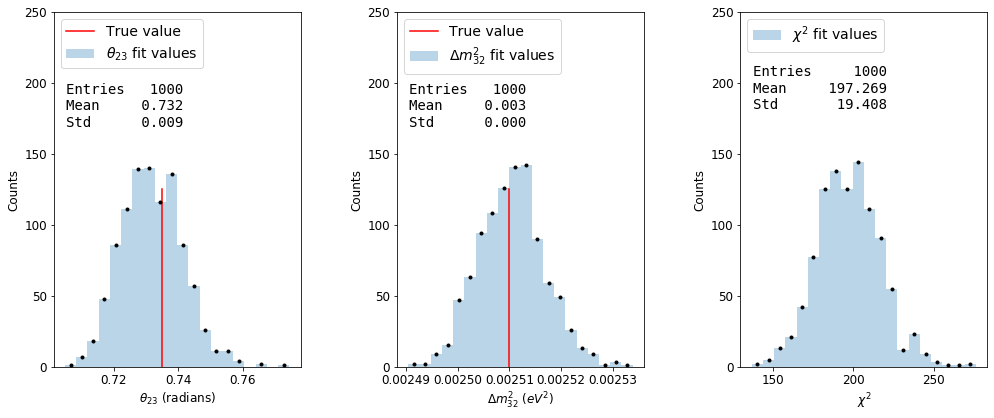

In [41]:
fig, axs = plt.subplots(1,3, figsize=(15,7))
axs.ravel()

true_val = [theta23_true, DM32_true]
x_labels = [r'$\theta_{23}$ (radians)', r'$\Delta m_{32}^2$ ($eV^2$)', r'$\chi^2$']

height = N_runs/4

for n in range(3):
    if n<2:
        axs[n].plot([true_val[n], true_val[n]], [0,height/2], 'r-', label='True value')
    axs[n].set_ylim(0,height)
    axs[n].set_ylabel('Counts')
    axs[n].set_xlabel(x_labels[n])

x_hist, y_hist, sy_hist, binwidth, theta23_mean, theta23_std = cef.make_hist(axs[0], theta23_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                             label=(r'$\theta_{23}$ fit values', ''), errors = False)
x_hist, y_hist, sy_hist, binwidth, DM32_mean, DM32_std = cef.make_hist(axs[1], DM32_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                             label=(r'$\Delta m_{32}^2$ fit values', ''),errors = False)
cef.make_hist(axs[2], chi2_array, Nbins=20, loc_dic = (0.05, 0.85), label=(r'$\chi^2$ fit values', ''),
              errors = False)

fig.tight_layout(pad=5.0);

In [42]:
z_theta_mean = abs((theta23_mean - theta23_true)/np.sqrt(theta23_std**2 + (1*np.pi/180)**2))
z_DM_mean = abs((DM32_mean - DM32_true)/np.sqrt(DM32_std**2 + (0.027e-3)**2))
print(z_theta_mean, z_DM_mean)

0.1507407456426684 0.015544288498929396


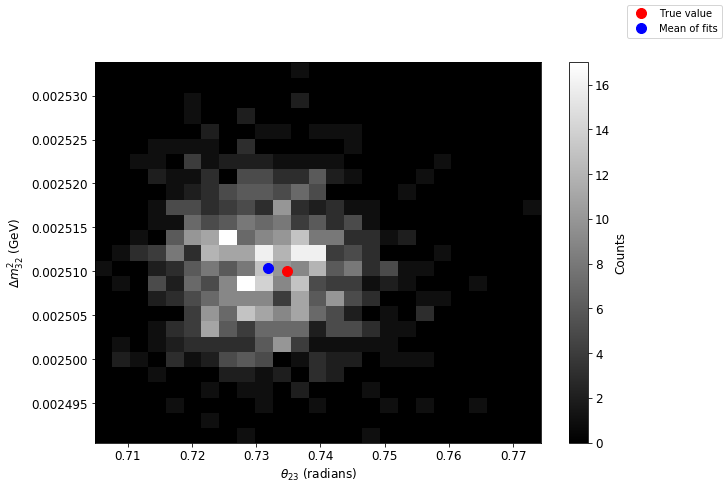

In [55]:
fig, ax = plt.subplots(figsize=(10,7))
im = ax.hist2d(theta23_fits, DM32_fits, bins=25, cmap='gray')
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label('Counts')
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
ax.plot(theta23_true, DM32_true, 'ro', markersize=10, label='True value')
ax.plot(theta23_mean, DM32_mean, 'bo', markersize=10, label='Mean of fits')
fig.legend();

theta23: 0.7313390806196429, DM32: 0.002501071505115345, chi^2: 196.92533604023708


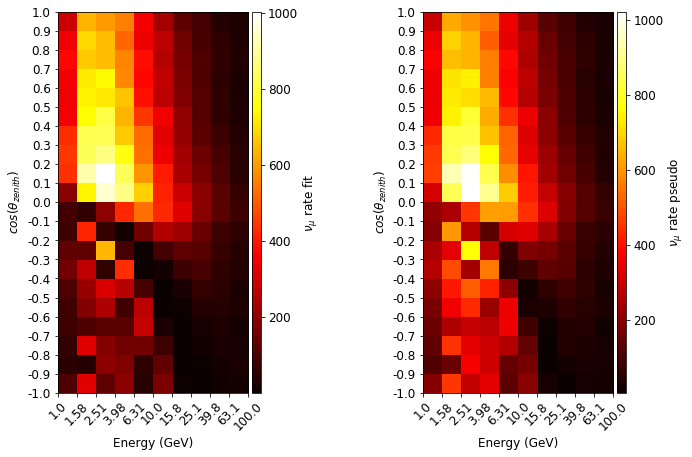

In [225]:
# new pseudo-data with fluctuations
r = np.random
Honda_pseudo_fluctuation_cc = r.poisson(Honda_pseudo_data_cc)  #.copy()
#Honda_pseudo_fluctuation_cc += r.poisson(np.sqrt(Honda_pseudo_data_cc))*(2*np.random.randint(0,2, size=(20,10))-1)

Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, Honda_rate_cc, 
                                                               Honda_pseudo_fluctuation_cc, ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print(f'theta23: {par_fluct[0]}, DM32: {par_fluct[1]}, chi^2: {Chi2_fluct}')

prob_numu_to_numu, osc_prob_binned = oop.prob_numu_numu(par_fluct[0], par_fluct[1])
fit_data = Honda_pseudo_fluctuation_cc * osc_prob_binned

fig, ax = plt.subplots(1, 2, figsize=(12,7))
ax.ravel()


im0 = ax[0].imshow(fit_data, cmap='hot')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)

cbar0 = plt.colorbar(im0, cax=cax0)
ax[0].set_xlabel('Energy (GeV)')
ax[0].set_ylabel(r'$cos(\theta_{zenith})$')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(energy_strings, rotation = 45)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
cbar_label0 = r'$\nu_{\mu}$ rate fit'
cbar0.set_label(cbar_label0)


im1 = ax[1].imshow(Honda_pseudo_fluctuation_cc, cmap='hot')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

cbar1 = plt.colorbar(im1, cax=cax1)
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_ylabel(r'$cos(\theta_{zenith})$')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(energy_strings, rotation = 45)
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
cbar_label1 = r'$\nu_{\mu}$ rate pseudo'
cbar1.set_label(cbar_label1)